In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm

# custom libs
import sys
sys.path.append("../")
from src.transformations import (
                            obtain_densities, 
                            mLQDT,
                            obtain_densities_from_lqd
                            )
from src.dynamicFPC import K_dFPC, W_dFPC
from src.forecasting import run_forecaster, train_test_split, overall_measures, expanding_window_cv, slice_fold
from src.preprocessing import align_densities
from sklearn.neighbors import KernelDensity
from src.preprocessing import weigh_norm_densities

# Data

In [2]:
# Dados
data_path = "../data/processed/"
returns_path = ''.join([data_path, 'ibovespa_treated.xlsx'])
df = pd.read_excel(returns_path, index_col="time")
df.head()

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-11-14,2025-11-17,2025-11-18,2025-11-19,2025-11-21,2025-11-24,2025-11-25,2025-11-26,2025-11-27,2025-11-28
time,,,,,,,,,,,,,,,,,,,,,
10:00:00,0.000011,-0.000372,-0.000035,0.007233,-0.001305,-0.000459,0.002388,0.002212,-0.008001,-0.000824,...,-0.000957,-0.002307,-0.003734,-0.005020,-0.001139,-0.000255,0.002339,0.004176,-0.000224,-0.000238
10:05:00,-0.002271,0.003372,0.001716,0.005538,0.000069,0.006429,0.002343,0.001918,-0.007582,-0.000413,...,-0.001522,0.000739,-0.000613,0.000306,-0.002021,-0.000810,0.001557,-0.001565,-0.000193,0.002906
10:10:00,-0.000582,0.002832,-0.000502,0.000739,0.000261,0.001891,0.000775,-0.001172,0.000216,-0.000432,...,0.000360,-0.000105,-0.000159,-0.000362,0.000092,0.001131,0.001170,0.000202,0.000556,0.000475
10:15:00,-0.001997,0.001091,0.000111,-0.000192,0.000407,-0.001392,-0.000477,-0.001526,0.000198,-0.001821,...,0.001121,-0.000284,0.003272,-0.001107,-0.001012,-0.000174,0.001002,0.001815,-0.000168,0.000973
10:20:00,-0.000037,-0.000505,-0.000327,-0.000580,-0.000436,-0.000405,0.001263,0.000676,-0.002667,0.001033,...,0.000449,0.000335,0.000853,0.000981,-0.000057,-0.000096,0.000832,0.001951,0.001060,-0.001004


Since T<300, this notebook will focus only on KdFPC and not WdFPC.

In [3]:
# Obtém objetos functionais
M=256
df_densities_supports, df_densities = obtain_densities(df, M=M)
df_densities.head()

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-11-14,2025-11-17,2025-11-18,2025-11-19,2025-11-21,2025-11-24,2025-11-25,2025-11-26,2025-11-27,2025-11-28
0,26.484908,26.956133,43.192058,125.280911,22.281346,38.967352,16.381520,14.790396,14.755901,68.336475,...,56.055614,22.715586,14.822458,15.843866,32.781883,18.742967,33.634914,25.011205,59.591366,35.178493
1,27.241643,27.122226,45.461265,136.723836,22.832775,42.242165,16.464708,15.775207,15.074789,69.601494,...,58.593015,23.234847,14.766766,15.786675,33.917251,18.731575,34.249709,26.274475,61.292412,36.765442
2,27.981593,27.202815,47.834014,148.806966,23.387308,45.782784,16.515723,16.786994,15.329547,70.785264,...,61.183942,23.741339,14.600942,15.616338,35.043756,18.633085,34.819063,27.580472,62.901117,38.343073
3,28.705446,27.201007,50.314130,161.520300,23.949408,49.622962,16.538115,17.828014,15.516788,71.884940,...,63.826668,24.236153,14.328695,15.336517,36.158932,18.451074,35.343181,28.937052,64.412209,39.906751
4,29.414414,27.121317,52.905301,174.848127,24.524079,53.799960,16.536236,18.901735,15.633996,72.898267,...,66.519367,24.720652,13.956058,14.953171,37.260436,18.190690,35.822792,30.353197,65.821467,41.452040


In [4]:
kernel = 'gaussian'
bandwidth = 0.001

m = 256
x_grid = np.linspace(df.min().min(), df.max().max(), 256)

l = []
for t in df.columns:
    kde = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    data = df.loc[:,t].values.reshape(-1,1)
    kde.fit(data)
    log_densities = kde.score_samples(x_grid.reshape(-1,1))
    densities = np.exp(log_densities)
    l.append(pd.Series(densities))

df_densities = pd.concat(l, axis=1)
df_densities.columns = df.columns
df_densities_supports = pd.concat([pd.Series(x_grid) for r in range(len(df.columns))], axis=1)
df_densities_supports.columns = df.columns

df_density_2 = weigh_norm_densities(df_densities, x_grid)

<Axes: >

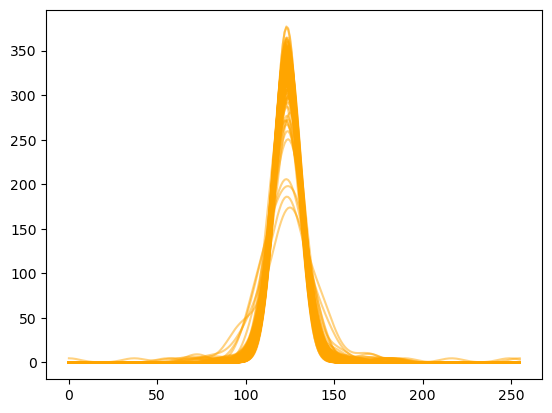

In [5]:
df_densities.plot(legend=False, alpha=.5, color="orange")

# Multistep OOS forecast

In [12]:
horizon = 10

In [13]:
Y_train_support, Y_train, Y_test_support, Y_test = train_test_split(
                                                                df_densities, 
                                                                df_densities_supports,
                                                                train_size=horizon)
Y_train.head()

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-10-31,2025-11-03,2025-11-04,2025-11-05,2025-11-06,2025-11-07,2025-11-10,2025-11-11,2025-11-12,2025-11-13
0,6.987786e-60,9.654552e-59,1.072963e-64,4.454296e-68,3.397759e-61,1.251835e-64,2.016900e-62,8.529718e-50,1.050474e-25,5.900334e-63,...,1.024879e-65,4.990528e-62,6.265402e-69,2.436555e-67,3.903252e-68,4.043231e-61,9.715318e-67,3.182946e-61,1.653402e-60,1.148776e-55
1,8.760168e-59,1.187765e-57,1.486416e-63,6.633049e-67,4.377091e-60,1.732856e-63,2.665609e-61,8.542933e-49,5.481167e-25,7.947678e-62,...,1.449322e-64,6.546934e-61,9.525199e-68,3.568237e-66,5.832573e-67,5.200233e-60,1.402549e-65,4.103040e-60,2.099315e-59,1.314034e-54
2,1.072816e-57,1.427460e-56,2.011560e-62,9.649301e-66,5.508217e-59,2.343258e-62,3.441441e-60,8.358170e-48,2.793898e-24,1.045813e-60,...,2.002120e-63,8.390180e-60,1.414682e-66,5.104921e-65,8.514466e-66,6.533543e-59,1.977938e-64,5.166731e-59,2.603805e-58,1.468284e-53
3,1.283447e-56,1.675840e-55,2.659272e-61,1.371284e-64,6.771253e-58,3.095425e-61,4.340262e-59,7.988168e-47,1.391230e-23,1.344367e-59,...,2.701772e-62,1.050381e-58,2.052598e-65,7.134823e-64,1.214280e-64,8.018747e-58,2.724838e-63,6.355648e-58,3.154794e-57,1.602674e-52
4,1.499930e-55,1.921923e-54,3.434236e-60,1.903742e-63,8.131295e-57,3.994510e-60,5.347163e-58,7.457875e-46,6.767673e-23,1.688233e-58,...,3.561562e-61,1.284592e-57,2.909441e-64,9.741753e-63,1.691786e-63,9.613822e-57,3.666927e-62,7.637262e-57,3.733924e-56,1.708884e-51


In [14]:
bovespa_mLQDT = mLQDT(
                    Y_train,
                    Y_train_support
                )
bovespa_mLQDT.densities_to_lqdensities(verbose=False)
df_lqds = bovespa_mLQDT.lqd.iloc[1:-1,:]
df_lqds_support = bovespa_mLQDT.lqd_support[1:-1]

In [15]:
KdFPC_kwargs = {
    "lag_max": 5,
    "alpha": 0.10,
    "du": 0.05,
    "B": 1000,
    "p": 5,
    "m": df_lqds.shape[0],
    "u": df_lqds_support,
    "select_ncomp": False,
    "dimension": 2
}

KdFPC_model = K_dFPC(df_lqds.values)
KdFPC_model.fit(**KdFPC_kwargs)
k_scores = KdFPC_model.etahat.real.T

In [16]:
maxlags_  = 10
criteria_ = 'bic'

k_etahat_fc = run_forecaster(k_scores, maxlags_, criteria_, horizon)

In [17]:
model = pm.auto_arima(
    bovespa_mLQDT.c,                         # univariate series
    seasonal=False,            # True if SARIMA
    error_action='ignore',     # ignore non-invertible models
    suppress_warnings=True,
    information_criterion='bic',
    trace=False
)

# Forecast h steps ahead
c_forecast, conf_int = model.predict(n_periods=horizon, return_conf_int=True)

In [18]:
k_curve_forecast = KdFPC_model.predict(k_etahat_fc)

df_k_forecast = pd.DataFrame(k_curve_forecast, columns=Y_test.columns)

In [19]:
kle_bkw_supports, kle_bkw_densities = obtain_densities_from_lqd(
                                                            df_k_forecast,
                                                            bovespa_mLQDT.lqd_support,
                                                            c_forecast,
                                                            verbose=False
                                                            )

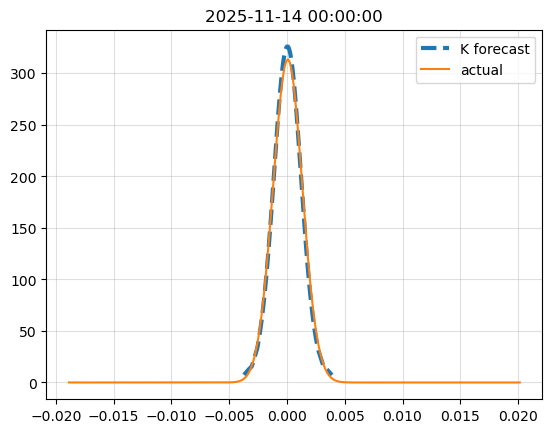

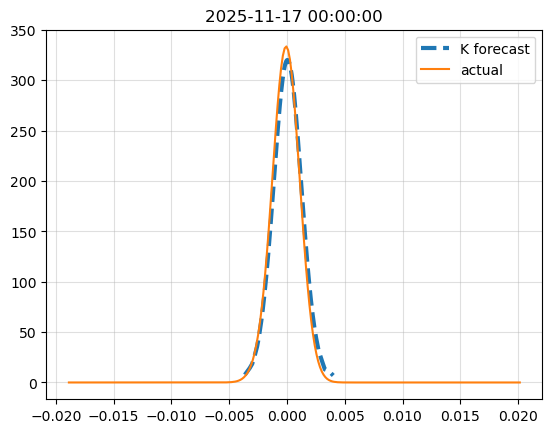

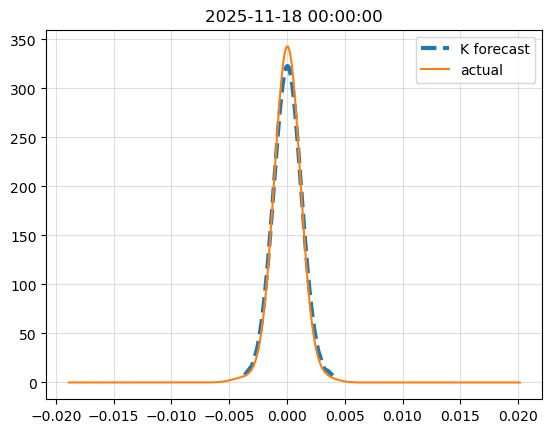

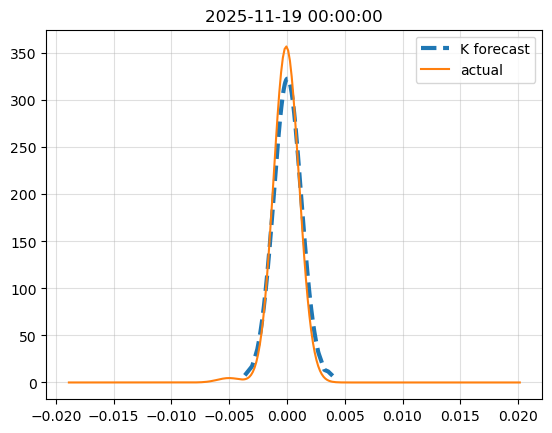

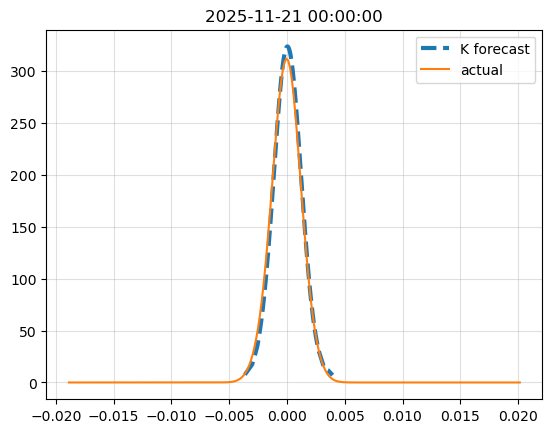

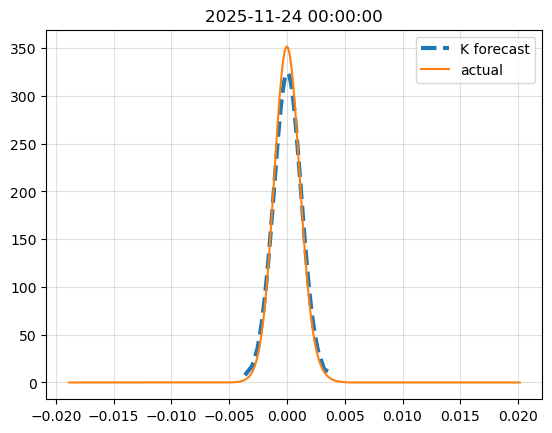

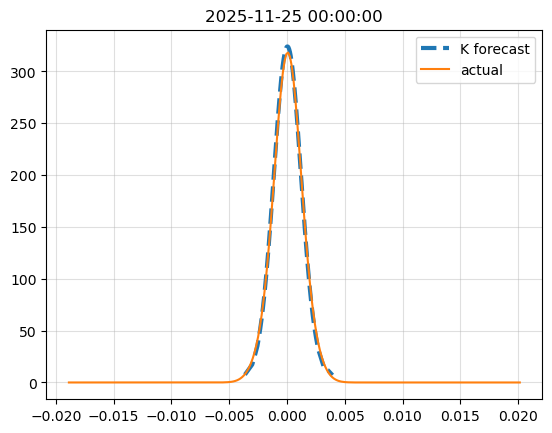

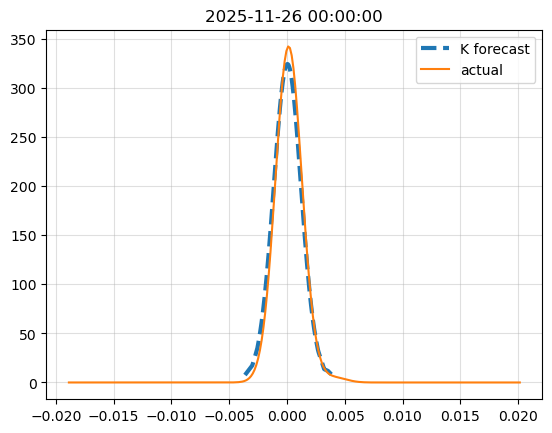

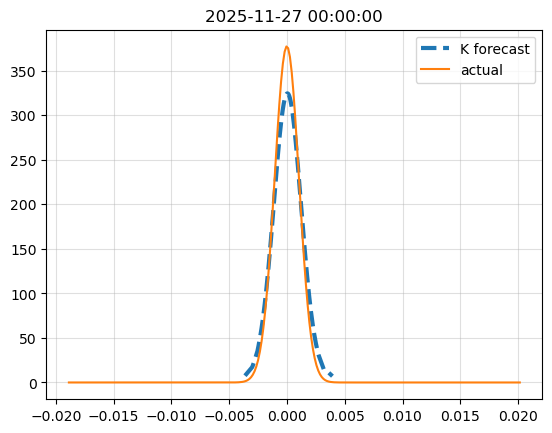

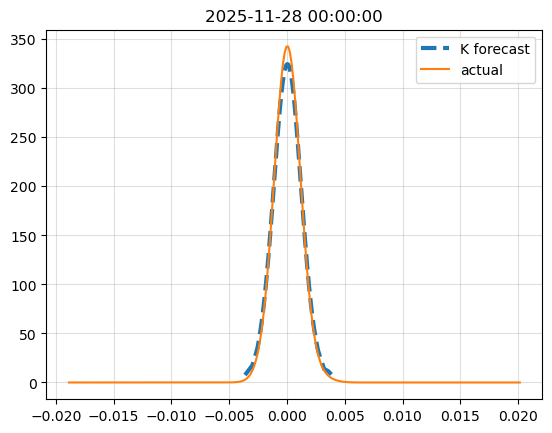

In [20]:
# Visualização
for t in range(horizon):
    col_name = Y_test.columns[t]

    test   = Y_test.loc[:,col_name]
    test_upp = Y_test_support.loc[:,col_name]
    k_t_fc = kle_bkw_densities.loc[:,col_name]
    k_t_fc_supp = kle_bkw_supports.loc[:,col_name]

    plt.figure()

    plt.plot(k_t_fc_supp, k_t_fc, label="K forecast", linestyle="--", linewidth=3)
    plt.plot(test_upp, test, label="actual")

    plt.legend()
    plt.title(f"{col_name}")
    plt.grid(True,linestyle="-", alpha=0.4)
    plt.show()

In [21]:
df_supp, df_f_kle, df_kle_fhat = align_densities(
                                Y_test_support, 
                                Y_test, 
                                kle_bkw_supports, 
                                kle_bkw_densities, 
                                kle_bkw_densities.columns)

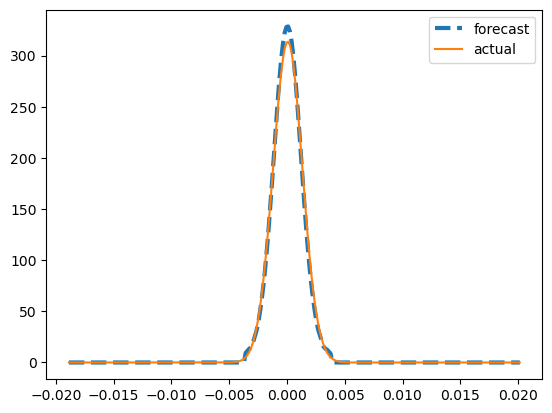

In [22]:
t=0

plt.figure()

plt.plot(df_supp.iloc[:,t], df_kle_fhat.iloc[:,t], linestyle="--", linewidth=3, label="forecast")
plt.plot(df_supp.iloc[:,t], df_f_kle.iloc[:,t], label="actual")

plt.legend()

plt.show()

In [23]:
print("KLE measures")
print(overall_measures(test=df_f_kle, forecast=df_kle_fhat))

KLE measures
{'KLD': np.float64(0.071584), 'JSD': np.float64(0.029599), 'Lnorm': np.float64(0.003698)}


In [24]:
msrs = overall_measures(test=df_f_kle, forecast=df_kle_fhat)

In [25]:
lista = []
lista.append(msrs)
lista.append(msrs)
lista.append(msrs)
lista

[{'KLD': np.float64(0.024636),
  'JSD': np.float64(0.028912),
  'Lnorm': np.float64(0.00366)},
 {'KLD': np.float64(0.024636),
  'JSD': np.float64(0.028912),
  'Lnorm': np.float64(0.00366)},
 {'KLD': np.float64(0.024636),
  'JSD': np.float64(0.028912),
  'Lnorm': np.float64(0.00366)}]

# Cross Validation

In [16]:
def workflow(Y, Y_support, horizon=1):
    windows = expanding_window_cv(Y.shape[1], h=horizon, initial_window=100)

    measures = []
    for fold, window in enumerate(windows):
        print(f"cv {fold}/{len(windows)}")
        idx_train = window[0]
        idx_test  = window[1]
        
        Y_train_support, Y_train = Y_support.iloc[:,idx_train], Y.iloc[:,idx_train]
        Y_test_support , Y_test = Y_support.iloc[:,idx_test],  Y.iloc[:,idx_test]

        bovespa_mLQDT = mLQDT(
                    Y_train,
                    Y_train_support
                )
        bovespa_mLQDT.densities_to_lqdensities(verbose=False)
        df_lqds = bovespa_mLQDT.lqd.iloc[1:-1,:]
        df_lqds_support = bovespa_mLQDT.lqd_support[1:-1]

        KdFPC_kwargs = {
            "lag_max": 5,
            "alpha": 0.10,
            "du": 0.05,
            "B": 1000,
            "p": 5,
            "m": df_lqds.shape[0],
            "u": df_lqds_support,
            "select_ncomp": False,
            "dimension": 2
        }

        KdFPC_model = K_dFPC(df_lqds.values)
        KdFPC_model.fit(**KdFPC_kwargs)
        k_scores = KdFPC_model.etahat.real.T

        maxlags_  = 10
        criteria_ = 'bic'

        k_etahat_fc = run_forecaster(k_scores, maxlags_, criteria_, horizon)

        model = pm.auto_arima(
            bovespa_mLQDT.c,                         # univariate series
            seasonal=False,            # True if SARIMA
            error_action='ignore',     # ignore non-invertible models
            suppress_warnings=True,
            information_criterion='bic',
            trace=False
        )

        # Forecast h steps ahead
        c_forecast, conf_int = model.predict(n_periods=horizon, return_conf_int=True)

        k_curve_forecast = KdFPC_model.predict(k_etahat_fc)

        df_k_forecast = pd.DataFrame(k_curve_forecast, columns=Y_test.columns)

        kle_bkw_supports, kle_bkw_densities = obtain_densities_from_lqd(
                                                                    df_k_forecast,
                                                                    bovespa_mLQDT.lqd_support,
                                                                    c_forecast,
                                                                    verbose=False
                                                                    )
        
        df_supp, df_f_kle, df_kle_fhat = align_densities(
                                        Y_test_support, 
                                        Y_test, 
                                        kle_bkw_supports, 
                                        kle_bkw_densities, 
                                        kle_bkw_densities.columns)

        
        d1 = {
            "fold": fold,
            "method": "KLE",
        }
        d1.update(overall_measures(test=df_f_kle, forecast=df_kle_fhat))
        measures.append(d1)

    return measures

In [ ]:
cv_measures = workflow(df_densities, df_densities_supports)

In [99]:
df_measures = pd.DataFrame(cv_measures)
df_measures_long = df_measures.melt(
    id_vars="method",
    value_vars=["KLD", "JSD", "Lnorm"],
    var_name="metric",
    value_name="value"
)

In [100]:
df_measures.to_excel("../data/processed/cv_measures_2.xlsx", index=False)

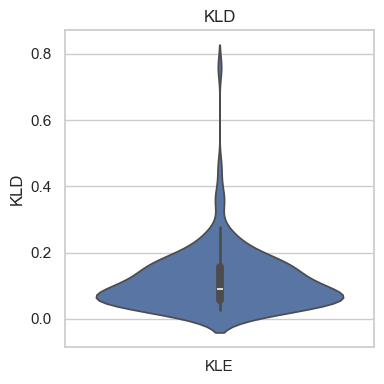

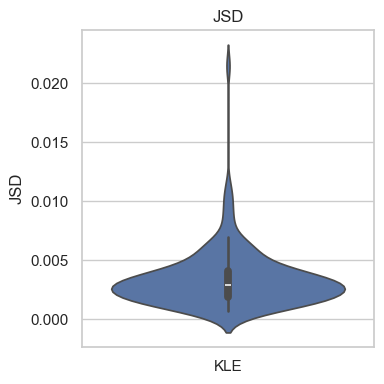

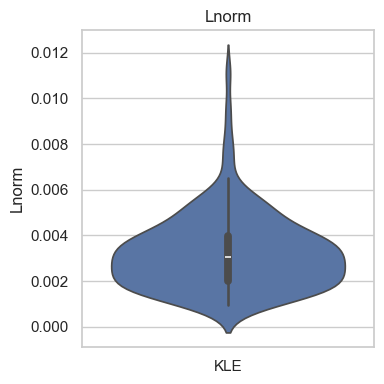

In [101]:
sns.set_theme(style="whitegrid")

measures = ["KLD", "JSD", "Lnorm"]

for m in measures:
    plt.figure(figsize=(4, 4))
    
    sns.violinplot(
        data=df_measures,
        x="method",
        y=m,
        inner="box"
    )
    
    plt.title(m)
    plt.xlabel("")
    plt.ylabel(m)
    plt.tight_layout()
    plt.show()

In [102]:
for measure in measures:
    print(f">Medida {measure}:")
    for method in df_measures["method"].unique():
        quantile = 0.5
        quantile_value = np.quantile(df_measures[df_measures.method == method][measure],quantile)
        print(f"\t Método {method}, quantil {quantile}: {quantile_value}")

>Medida KLD:
	 Método KLE, quantil 0.5: 0.089437
>Medida JSD:
	 Método KLE, quantil 0.5: 0.002911
>Medida Lnorm:
	 Método KLE, quantil 0.5: 0.003064


## Selecting number of dimensions

In [12]:
n_cv_folds = 150
cv_start_index = df_densities.shape[1] - n_cv_folds
horizon=1
D = np.arange(2,10)

windows = expanding_window_cv(
                            df_densities.shape[1], 
                            h=horizon, 
                            initial_window=cv_start_index
                            )

results = []

for d in D:
    print(f"CV for d={d}")

    for fold, (train_idx, test_idx) in enumerate(windows):
        print(f"\t cv {fold+1}/{len(windows)}")
            
        data = slice_fold(df_densities, df_densities_supports, train_idx, test_idx)
        Y_train_support, Y_train = data["Y_support_train"], data["Y_train"]
        Y_test_support , Y_test  = data["Y_support_test"],  data["Y_test"]

        bovespa_mLQDT = mLQDT(
                    Y_train,
                    Y_train_support
                )
        bovespa_mLQDT.densities_to_lqdensities(verbose=False)
        df_lqds = bovespa_mLQDT.lqd.iloc[1:-1,:]
        df_lqds_support = bovespa_mLQDT.lqd_support[1:-1]

        KdFPC_kwargs = {
            "p": 5,
            "u": df_lqds_support,
            "dimension": d
        }

        KdFPC_model = K_dFPC(df_lqds.values)
        KdFPC_model.fit(**KdFPC_kwargs)
        k_scores = KdFPC_model.etahat.real.T

        maxlags_  = 10
        criteria_ = 'bic'

        k_etahat_fc = run_forecaster(k_scores, maxlags_, criteria_, horizon)

        model = pm.auto_arima(
            bovespa_mLQDT.c,                         # univariate series
            seasonal=False,            # True if SARIMA
            error_action='ignore',     # ignore non-invertible models
            suppress_warnings=True,
            information_criterion='bic',
            trace=False
        )

        # Forecast h steps ahead
        c_forecast, conf_int = model.predict(n_periods=horizon, return_conf_int=True)

        k_curve_forecast = KdFPC_model.predict(k_etahat_fc)

        df_k_forecast = pd.DataFrame(k_curve_forecast, columns=Y_test.columns)

        kle_bkw_supports, kle_bkw_densities = obtain_densities_from_lqd(
                                                                    df_k_forecast,
                                                                    bovespa_mLQDT.lqd_support,
                                                                    c_forecast,
                                                                    verbose=False
                                                                    )
        
        df_supp, df_f_kle, df_kle_fhat = align_densities(
                                        Y_test_support, 
                                        Y_test, 
                                        kle_bkw_supports, 
                                        kle_bkw_densities, 
                                        kle_bkw_densities.columns)

        
        d1 = {
            "fold": fold,
            "method": "KLE",
            "d": d
        }
        d1.update(overall_measures(test=df_f_kle, forecast=df_kle_fhat))
        results.append(d1)

CV for d=2
	 cv 1/150
	 cv 2/150
	 cv 3/150
	 cv 4/150
	 cv 5/150
	 cv 6/150
	 cv 7/150
	 cv 8/150
	 cv 9/150
	 cv 10/150
	 cv 11/150
	 cv 12/150
	 cv 13/150
	 cv 14/150
	 cv 15/150
	 cv 16/150
	 cv 17/150
	 cv 18/150
	 cv 19/150
	 cv 20/150
	 cv 21/150
	 cv 22/150
	 cv 23/150
	 cv 24/150
	 cv 25/150
	 cv 26/150
	 cv 27/150
	 cv 28/150
	 cv 29/150
	 cv 30/150
	 cv 31/150
	 cv 32/150
	 cv 33/150
	 cv 34/150
	 cv 35/150
	 cv 36/150
	 cv 37/150
	 cv 38/150
	 cv 39/150
	 cv 40/150
	 cv 41/150
	 cv 42/150
	 cv 43/150
	 cv 44/150
	 cv 45/150
	 cv 46/150
	 cv 47/150
	 cv 48/150
	 cv 49/150
	 cv 50/150
	 cv 51/150
	 cv 52/150
	 cv 53/150
	 cv 54/150
	 cv 55/150
	 cv 56/150
	 cv 57/150
	 cv 58/150
	 cv 59/150
	 cv 60/150
	 cv 61/150
	 cv 62/150
	 cv 63/150
	 cv 64/150
	 cv 65/150
	 cv 66/150
	 cv 67/150
	 cv 68/150
	 cv 69/150
	 cv 70/150
	 cv 71/150
	 cv 72/150
	 cv 73/150
	 cv 74/150
	 cv 75/150
	 cv 76/150
	 cv 77/150
	 cv 78/150
	 cv 79/150
	 cv 80/150
	 cv 81/150
	 cv 82/150
	 cv 83/150
	 

ValueError: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.

In [14]:
df_measures = pd.DataFrame(results)
df_measures_long = df_measures.melt(
    id_vars=["method", "d"],
    value_vars=["KLD", "JSD", "L_1", "L_2", "L_INFTY", "d"],
    var_name="metric",
    value_name="value"
)

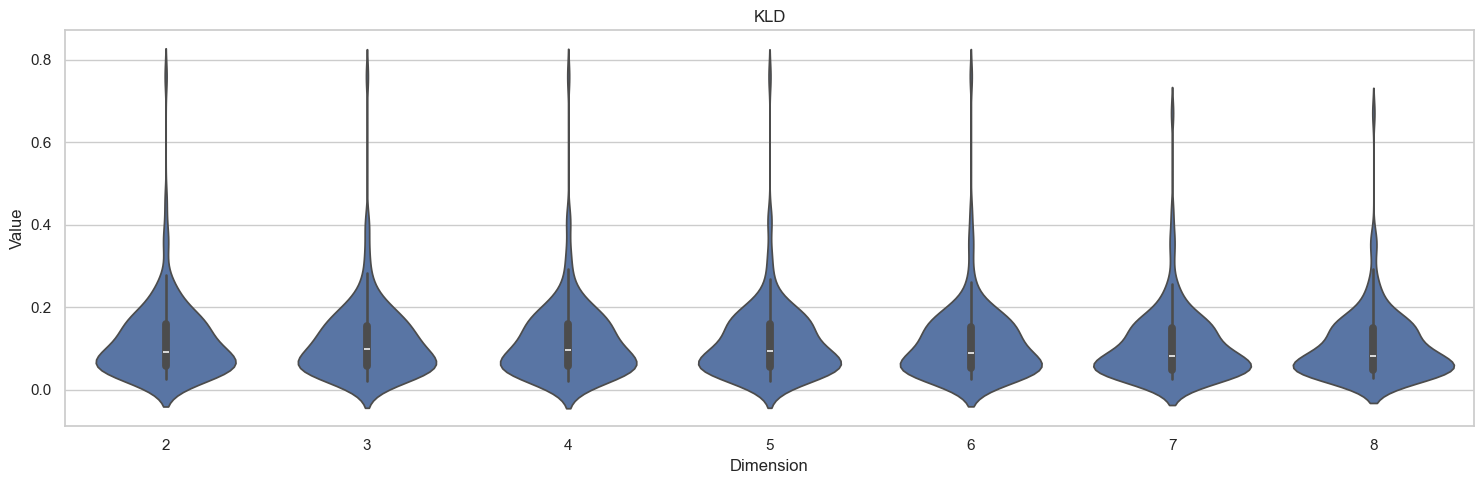

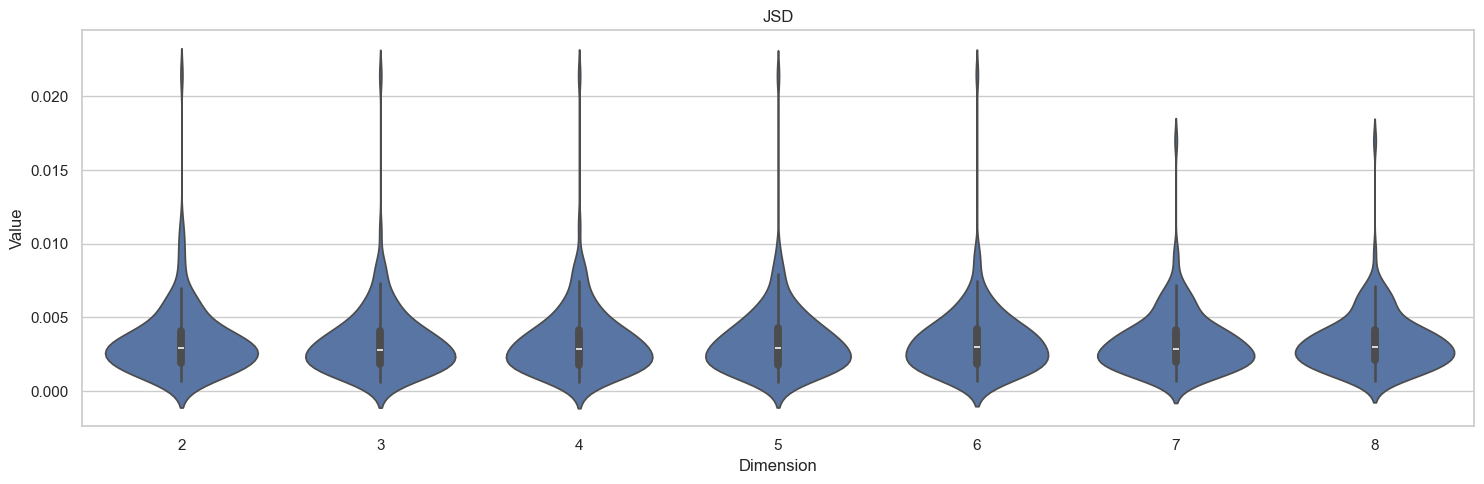

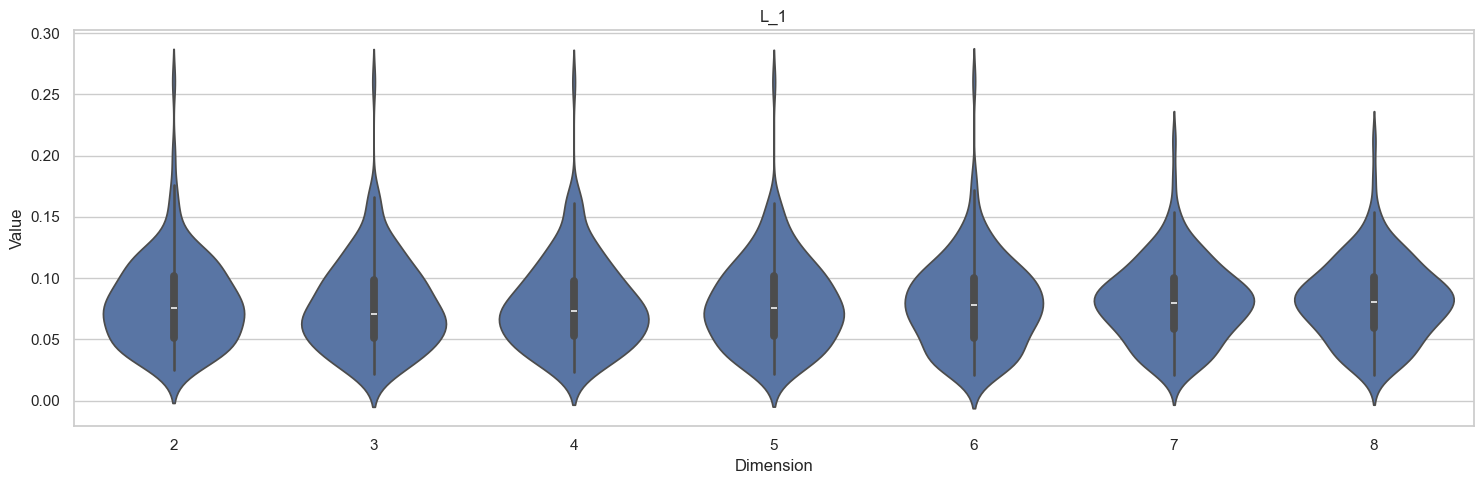

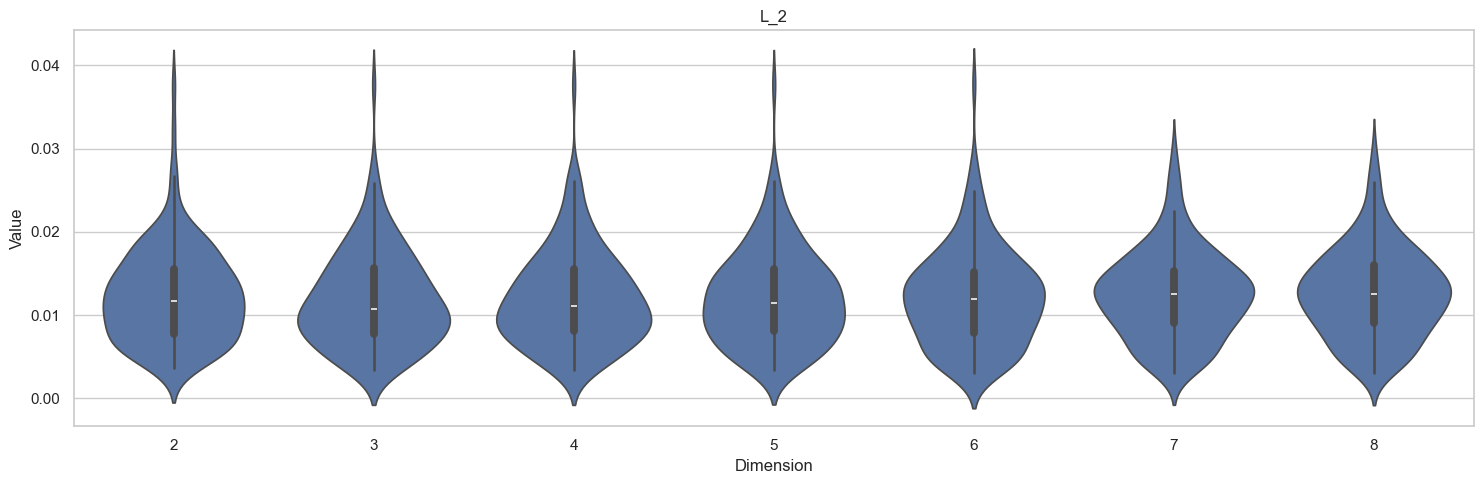

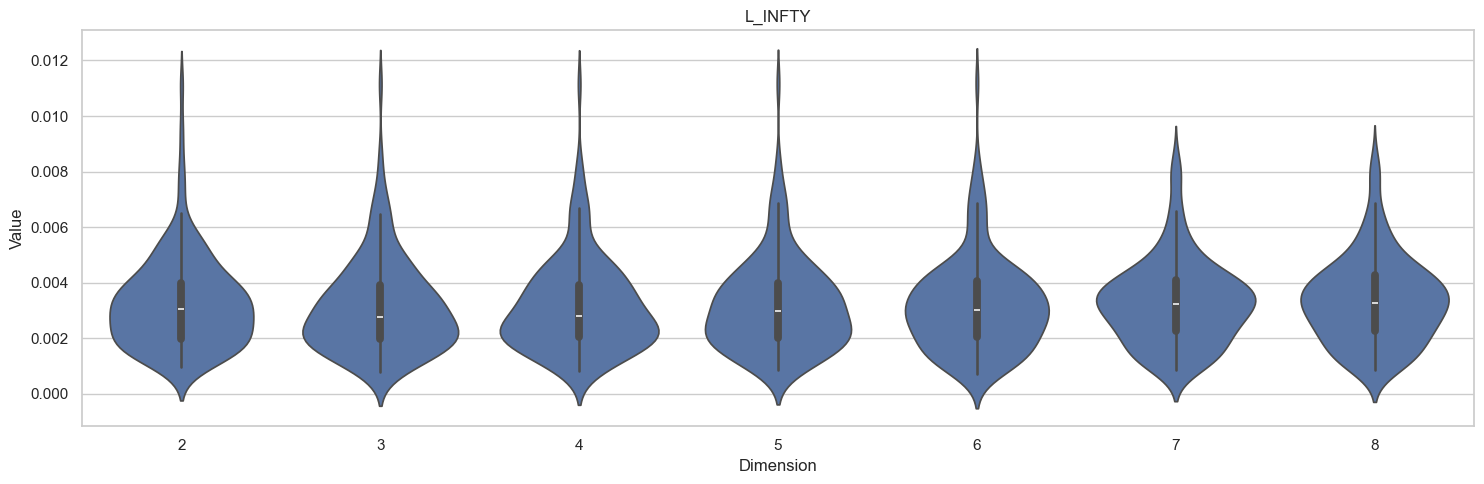

In [15]:
sns.set_theme(style="whitegrid")

measures = ["KLD", "JSD", "L_1", "L_2", "L_INFTY"]

for m in measures:
    plt.figure(figsize=(15, 5))
    
    sns.violinplot(
        data=df_measures,
        x="d",
        y=m,
        inner="box"
    )
    
    plt.title(m)
    plt.xlabel("Dimension")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

In [29]:
df_measures_medians = df_measures_long.groupby(["metric", "d"], as_index=False)["value"].median()
df_measures_medians

,metric,d,value
0,JSD,2,0.002928
1,JSD,3,0.002780
2,JSD,4,0.002874
3,JSD,5,0.002938
4,JSD,6,0.003013
5,JSD,7,0.002856
6,JSD,8,0.002999
7,KLD,2,0.091351
8,KLD,3,0.097633
9,KLD,4,0.095635


In [30]:
winners = (
    df_measures_medians
    .loc[df_measures_medians.groupby("metric")["value"].idxmin()]   # pick best d per metric
)
counts = winners["d"].value_counts()
best_d = counts.idxmax()
best_d

np.int64(3)